# 2D Funnel analysis

We provide a normalizing flow solution to the 2D Funnel problem.
This means defining the functions $f:X\rightarrow Z$ and $g:Z\rightarrow X$ where $f^{-1} = g$.
We define the 2D funnel as $x_1\sim N(0, 1), x_2\sim N(0, \exp(x_1)^2)$.

The solution is very simple. We then provide the same solution under SINF/SNF constraints.
We verify the equality of both solutions and provide visualizations for clarity.
Our results suggest that SNF could learn the 2D Funnel solution more easily if we:
* had more flexible activation functions,
* added additional dimensions to facilitate information flow.

This solution can easily be extended to the ND Funnel.

## General normalizing flow solution

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def f(x1, x2):
    """
    Normalizing function for the 2D funnel.
    The 2D funnel is defined as x1 ~ N(0, 1) and x2 ~ N(0, exp(x1)^2) where exp(x1) is the standard deviation.
    """
    return x1, x2 / np.exp(x1)


def g(z1, z2):
    """
    Generating function for the 2D funnel.
    This is the inverse of f.
    """
    return z1, z2 * np.exp(z1)

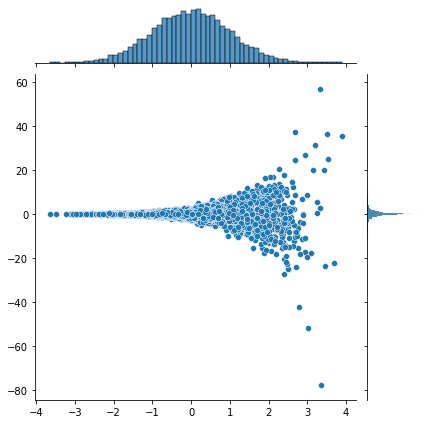

In [2]:
# Testing the generative direction

z_samples = np.random.randn(10000, 2)  # Create samples in the latent space
x_samples = np.c_[g(z_samples[:, 0], z_samples[:, 1])]  # Transform them to the original space
sns.jointplot(x=x_samples[:, 0], y=x_samples[:, 1]);  # Visualize samples in the original space

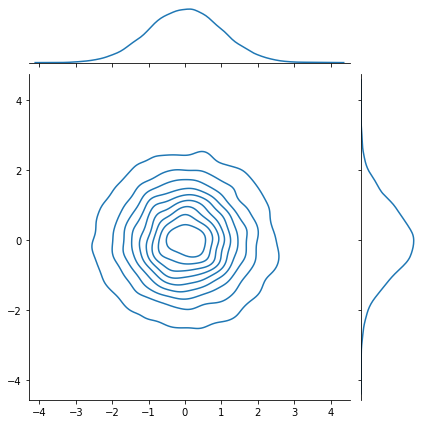

In [3]:
# Testing the normalizing direction

z_samples = np.c_[f(x_samples[:, 0], x_samples[:, 1])]  # Transform samples to the latent space
sns.jointplot(x=z_samples[:, 0], y=z_samples[:, 1], kind='kde');  # Visualize samples in the latent space

## SNF solution

What is the corresponding SINF/SNF model?

* inputs to $f$ should be $[x_1, x_2, k]^T$ instead of $[x_1, x_2]^T$
* inputs to $g$ should be $[z_1, z_2, k]^T$ instead of $[z_1, z_2]^T$
* all matrices A are $I_3$
* $\Psi^{(1)}(a, b, c) = (a, b, \exp(a)) \Rightarrow \Psi^{-(1)}(a, b, c) = (a, b, c / \exp(a))$
* $\Psi^{(2)}(a, b, c) = (a, b/c, c) \Rightarrow \Psi^{-(2)}(a, b, c) = (a, bc, c)$
* $\Psi^{(3)}(a, b, c) = (a, b, k) \Rightarrow \Psi^{-(3)}(a, b, c) = (a, b, \exp(a))$
* $k$ is any fixed real number, e.g. 1.

We test this below.

In [4]:
k = 0
A = np.eye(3)


class Psi1:
    @staticmethod
    def forward(x):
        x_copy = np.copy(x)
        x_copy[:, 2] = np.exp(x[:, 0])
        return x_copy

    @staticmethod
    def inverse(z):
        z_copy = np.copy(z)
        z_copy[:, 2] = z[:, 2] / np.exp(z[:, 0])
        return z_copy


class Psi2:
    @staticmethod
    def forward(x):
        x_copy = np.copy(x)
        x_copy[:, 1] = x[:, 1] / x[:, 2]
        return x_copy

    @staticmethod
    def inverse(z):
        z_copy = np.copy(z)
        z_copy[:, 1] = z[:, 1] * z[:, 2]
        return z_copy


class Psi3:
    @staticmethod
    def forward(x):
        x_copy = np.copy(x)
        x_copy[:, 2] = k
        return x_copy

    @staticmethod
    def inverse(z):
        z_copy = np.copy(z)
        z_copy[:, 2] = np.exp(z[:, 0])
        return z_copy


class Transform:
    def __init__(self, Psi):
        self.Psi = Psi

    def forward(self, x):
        return x + (A @ (self.Psi.forward((A @ x.T).T) - (A @ x.T).T).T).T

    def inverse(self, x):
        return x + (A @ (self.Psi.inverse((A @ x.T).T) - (A @ x.T).T).T).T

In [5]:
np.random.seed(0)
n_samples = 1000

# Sample in the latent space
snf_z = np.c_[np.random.randn(n_samples, 2), k * np.ones((n_samples, 1))]

# Define the flow
t1 = Transform(Psi1)
t2 = Transform(Psi2)
t3 = Transform(Psi3)

# Transform samples into the original space
snf_x = t1.inverse(t2.inverse(t3.inverse(snf_z)))

In [6]:
# Check that original space samples are correctly constructed from latent space samples
assert np.isclose(t3.forward(t2.forward(t1.forward(snf_x))), snf_z).all()

# Check that our Funnel samples match those from the analytic Funnel generator g
assert np.isclose(np.c_[g(snf_z[:, 0], snf_z[:, 1])], snf_x[:, :2]).all()

# Check that intermediate values after Psi1 are correct
assert np.isclose(snf_x[:, 0], t1.forward(snf_x)[:, 0]).all()
assert np.isclose(snf_x[:, 1], t1.forward(snf_x)[:, 1]).all()
assert np.isclose(np.exp(snf_x[:, 0]), t1.forward(snf_x)[:, 2]).all()

# Check that intermediate values after Psi2 are correct
assert np.isclose(snf_x[:, 0], t2.forward(t1.forward(snf_x))[:, 0]).all()
assert np.isclose(snf_x[:, 1] / np.exp(snf_x[:, 0]), t2.forward(t1.forward(snf_x))[:, 1]).all()
assert np.isclose(np.exp(snf_x[:, 0]), t2.forward(t1.forward(snf_x))[:, 2]).all()

# Check that intermediate values after Psi3 are correct
assert np.isclose(snf_x[:, 0], t3.forward(t2.forward(t1.forward(snf_x)))[:, 0]).all()
assert np.isclose(snf_x[:, 1] / np.exp(snf_x[:, 0]), t3.forward(t2.forward(t1.forward(snf_x)))[:, 1]).all()
assert np.isclose(k, t3.forward(t2.forward(t1.forward(snf_x)))[:, 2]).all()

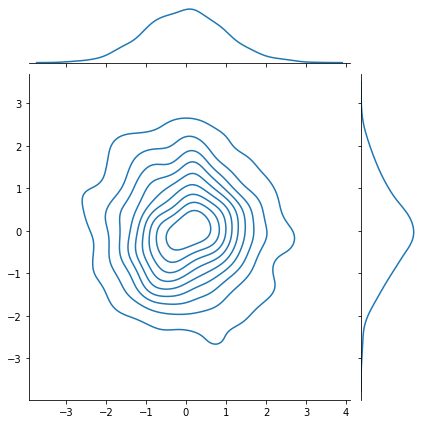

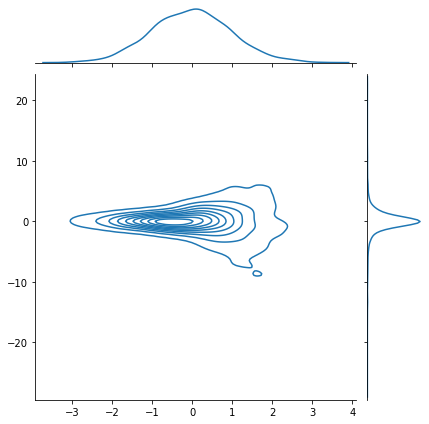

In [7]:
# The distribution of latent samples from the 2D Gaussian.
sns.jointplot(x=snf_z[:, 0], y=snf_z[:, 1], kind='kde')
plt.show()

# The distribution of Funnel samples, obtained via SNF.
sns.jointplot(x=snf_x[:, 0], y=snf_x[:, 1], kind='kde')
plt.show()

These results mean that there exists a three-layer SNF solution for the 2D Funnel.
To realize it, we would need more flexible activation functions $\Psi$ and we would need to allow additional dimensions in the flow, even though their outputs wouldn't be used for optimization.

The solution also uses identity matrices A, which are in the Stiefel manifold, but it is not clear whether going from some random matrix on the manifold to the identity takes a short or long time.
If it takes too long, one option is to allow identity matrices A in special kinds of transport layers.